In [1]:
import os, glob, sys
import numpy as np
import pandas as pd

## Load all the data so we explore it. 
pfile = '../Data/training_2024-11-04.pickle'
pfile_test = '../Data/testing_2024-11-04.pickle'
if os.path.isfile(pfile):
  SEPSISdat = pd.DataFrame.from_dict(pd.read_pickle(pfile))
print(len(SEPSISdat.patient)) # should be n=200112

if os.path.isfile(pfile_test):
  SEPSISdat_test = pd.DataFrame.from_dict(pd.read_pickle(pfile_test))
print(len(SEPSISdat_test.patient)) # should be n=41993

200112
41993


In [2]:
## Forward-fill missing values
SEPSISdat.update(SEPSISdat.groupby('patient').ffill())
SEPSISdat_test.update(SEPSISdat_test.groupby('patient').ffill())

In [3]:
## Get reference ranges for variables using only non-sepsis patients as 'normal'
SEPSISdat_NOsepsis = SEPSISdat[~SEPSISdat.patient.isin(np.unique(SEPSISdat.patient[SEPSISdat.SepsisLabel==1]))]
SEPSISdat_NOsepsis = SEPSISdat_NOsepsis[SEPSISdat_NOsepsis.ICULOS>1]
SEPSISdat_NOsepsis.drop(['patient','SepsisLabel','Sex'],axis=1,inplace=True)
meanSEPSISdat = round(SEPSISdat_NOsepsis.mean(axis=0),2)
sdSEPSISdat = round(SEPSISdat_NOsepsis.std(axis=0),2)
np.set_printoptions(suppress=True)
print('x_mean = np.array(')
print(np.array(meanSEPSISdat),')')
print('x_std = np.array(')
print(np.array(sdSEPSISdat),')')

x_mean = np.array(
[ 22.48  83.57  97.24  36.92 123.13  81.84  62.91  18.25  -0.46   0.5
   7.39  40.32  20.48   7.82   1.34 131.07   2.04   4.14  31.47  10.58
  11.46 196.31  62.25] )
x_std = np.array(
[15.22 16.51  2.88  0.71 22.19 15.71 13.51  4.95  3.39  0.18  0.06  7.28
 16.33  2.13  1.57 42.49  0.37  0.56  5.34  1.87  5.37 93.23 15.82] )


In [4]:
## Obtain the z-scores for all the variables
SEPSISdat_zScores = SEPSISdat
SEPSISdat_test_zScores = SEPSISdat_test
cols = SEPSISdat_zScores.columns.drop(['patient','SepsisLabel','Sex'])
for c in cols:
  SEPSISdat_zScores[c] = (SEPSISdat_zScores[c]-meanSEPSISdat[c])/sdSEPSISdat[c]
  SEPSISdat_test_zScores[c] = (SEPSISdat_test_zScores[c]-meanSEPSISdat[c])/sdSEPSISdat[c]

In [5]:
## Replace values still missing with the mean
SEPSISdat_zScores = SEPSISdat_zScores.fillna(0)
SEPSISdat_test_zScores = SEPSISdat_test_zScores.fillna(0)

const= [-4.0435]
coeffs = np.array(
[[ 0.1914  0.1191 -0.0031  0.3432  0.0792 -0.1973 -0.0089  0.0857  0.0224
   0.2323 -0.002   0.0038  0.1466 -0.0475  0.0732  0.0784 -0.043  -0.169
  -0.1041  0.096   0.0938  0.0728 -0.0367]] )
AUC: 0.733
AUC_test: 0.71
thresh= 0.0287


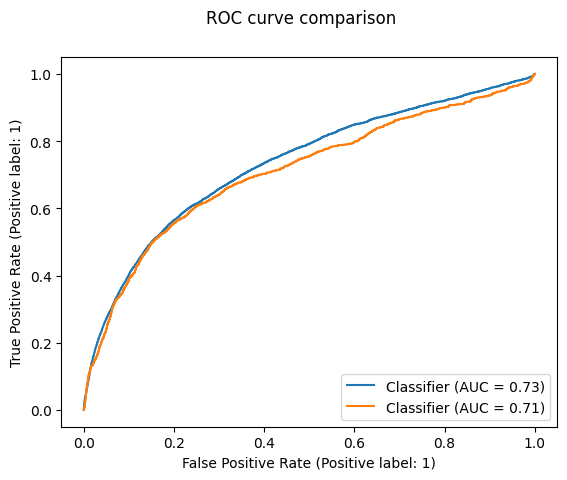

In [7]:
#### OPTION 1: LOGISTIC REGRESSION ####
## Build a logistic regression using all the training data
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression(random_state=0)
lreg.fit(SEPSISdat_zScores.iloc[:,1:24],SEPSISdat_zScores.SepsisLabel)
print('const=',np.round(lreg.intercept_,4))
print('coeffs = np.array(')
print(np.round(lreg.coef_,4),')')

## Add the predictions [Note: column 1 is the filename, which you don't get to see in the scoring and isn't helpful otherwise here]
SEPSISdat_zScores = SEPSISdat_zScores.assign(probSepsisLR=lreg.predict_proba(SEPSISdat_zScores.iloc[:,1:24])[::,1])
SEPSISdat_test_zScores = SEPSISdat_test_zScores.assign(probSepsisLR=lreg.predict_proba(SEPSISdat_test_zScores.iloc[:,1:24])[::,1])
#print(SEPSISdat_zScores)

## Quick but not necessarily great way to find a threshold. Also calculate the AUC
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
fpr, tpr, thresholds = roc_curve(SEPSISdat_zScores.SepsisLabel,SEPSISdat_zScores.probSepsisLR)
fpr1, tpr1, thresholds1 = roc_curve(SEPSISdat_test_zScores.SepsisLabel,SEPSISdat_test_zScores.probSepsisLR)
train_disp=RocCurveDisplay.from_predictions(SEPSISdat_zScores.SepsisLabel,SEPSISdat_zScores.probSepsisLR)
test_disp=RocCurveDisplay.from_predictions(SEPSISdat_test_zScores.SepsisLabel,SEPSISdat_test_zScores.probSepsisLR, ax=train_disp.ax_)
train_disp.figure_.suptitle("ROC curve comparison")
print('AUC:',round(roc_auc_score(SEPSISdat_zScores.SepsisLabel,SEPSISdat_zScores.probSepsisLR),3))
print('AUC_test:',round(roc_auc_score(SEPSISdat_test_zScores.SepsisLabel,SEPSISdat_test_zScores.probSepsisLR),3))
thresh=round(thresholds[np.argmax(tpr - fpr)],4)
print('thresh=',thresh)

In [8]:
# Quick calculation of utility score
SEPSISdat = SEPSISdat.assign(SepsisLabelLR = (SEPSISdat_zScores.probSepsisLR>thresh).astype(int))
SEPSISdat_test= SEPSISdat_test.assign(SepsisLabelLR = (SEPSISdat_test_zScores.probSepsisLR>thresh).astype(int))

import evaluate_sepsis_score as ev
util = ev.evaluate_utility(SEPSISdat.patient,np.array(SEPSISdat_zScores.SepsisLabel),np.array(SEPSISdat.SepsisLabelLR))
print(util)
util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(SEPSISdat_test_zScores.SepsisLabel),np.array(SEPSISdat_test.SepsisLabelLR))
print(util_test)

100%|█████████████████████████████████████████████████████████| 5000/5000 [03:10<00:00, 26.21it/s]


0.3447


100%|████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 130.75it/s]

0.3267


[LightGBM] [Info] Number of positive: 5303, number of negative: 194809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4396
[LightGBM] [Info] Number of data points in the train set: 200112, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.026500 -> initscore=-3.603747
[LightGBM] [Info] Start training from score -3.603747
AUC: 0.838
AUC_test: 0.743
Threshold: 0.035


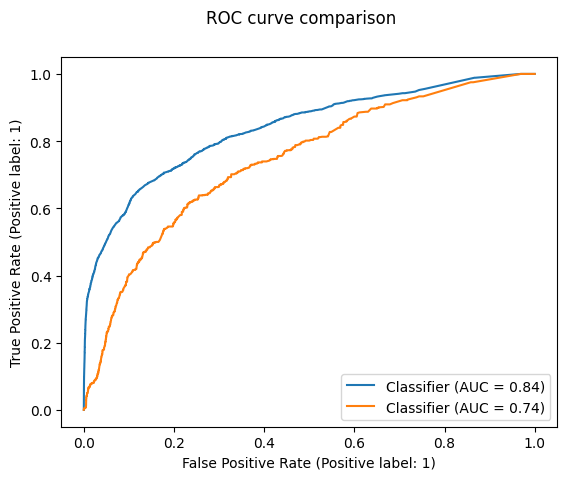

In [8]:
#### OPTION 2: BOOSTED TREE #####
## Build a LightGBM model using all the training data
import lightgbm as lgb
train_data = lgb.Dataset(data=SEPSISdat_zScores.iloc[:,1:24], label=SEPSISdat_zScores.SepsisLabel)
param = {'objective': 'binary'}
bst = lgb.train(param, train_data, 10)

## Add the predictions [Note: column 1 is the filename, which you don't get to see in the scoring and isn't helpful otherwise here]
SEPSISdat_zScores = SEPSISdat_zScores.assign(probSepsisGBM=bst.predict(data=SEPSISdat_zScores.iloc[:,1:24]))
SEPSISdat_test_zScores = SEPSISdat_test_zScores.assign(probSepsisGBM=bst.predict(data=SEPSISdat_test_zScores.iloc[:,1:24]))

## Quick but not necessarily great way to find a threshold. Also calculate the AUC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(SEPSISdat_zScores.SepsisLabel,SEPSISdat_zScores.probSepsisGBM)
fpr1, tpr1, thresholds1 = roc_curve(SEPSISdat_test_zScores.SepsisLabel,SEPSISdat_test_zScores.probSepsisGBM)
train_disp=RocCurveDisplay.from_predictions(SEPSISdat_zScores.SepsisLabel,SEPSISdat_zScores.probSepsisGBM)
test_disp=RocCurveDisplay.from_predictions(SEPSISdat_test_zScores.SepsisLabel,SEPSISdat_test_zScores.probSepsisGBM, ax=train_disp.ax_)
train_disp.figure_.suptitle("ROC curve comparison")

print('AUC:',round(roc_auc_score(SEPSISdat_zScores.SepsisLabel,SEPSISdat_zScores.probSepsisGBM),3))
print('AUC_test:',round(roc_auc_score(SEPSISdat_test_zScores.SepsisLabel,SEPSISdat_test_zScores.probSepsisGBM),3))

# Save the model and get the threshold for use as a model
bst.save_model('lightgbm.model')
thresh=round(thresholds[np.argmax(tpr - fpr)],4)
print('Threshold:',thresh)

In [10]:
# Quick calculation of utility score
SEPSISdat = SEPSISdat.assign(SepsisLabelGBM = (SEPSISdat_zScores.probSepsisGBM>thresh).astype(int))
SEPSISdat_test= SEPSISdat_test.assign(SepsisLabelGBM = (SEPSISdat_test_zScores.probSepsisGBM>thresh).astype(int))

import evaluate_sepsis_score as ev
util = ev.evaluate_utility(SEPSISdat.patient,np.array(SEPSISdat_zScores.SepsisLabel),np.array(SEPSISdat.SepsisLabelGBM))
print(util)
util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(SEPSISdat_test_zScores.SepsisLabel),np.array(SEPSISdat_test.SepsisLabelGBM))
print(util_test)

100%|█████████████████████████████████████████████████████████| 5000/5000 [03:15<00:00, 25.53it/s]


0.5076


100%|████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.55it/s]

0.3339


In [ ]:
## OPTION 4: Support Vector Machine ##
exit(0)
from sklearn import svm
clf = svm.LinearSVC(max_iter=3000)
clf.fit(SEPSISdat_zScores.iloc[:,1:24],SEPSISdat_zScores.SepsisLabel)

## Add the predictions
SEPSISdat_zScores = SEPSISdat_zScores.assign(probSepsisSVM=clf.predict(SEPSISdat_zScores.iloc[:,1:24]))
SEPSISdat_test_zScores = SEPSISdat_test_zScores.assign(probSepsisSVM=clf.predict(SEPSISdat_test_zScores.iloc[:,1:24]))

## Quick but not necessarily great way to find a threshold. Also calculate the AUC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(SEPSISdat_zScores.SepsisLabel,SEPSISdat_zScores.probSepsisSVM)
print('AUC:',round(roc_auc_score(SEPSISdat_zScores.SepsisLabel,SEPSISdat_zScores.probSepsisSVM),2))
print('AUC_test:',round(roc_auc_score(SEPSISdat_test_zScores.SepsisLabel,SEPSISdat_test_zScores.probSepsisSVM),2))
thresh=round(thresholds[np.argmax(tpr - fpr)],4)
print('Threshold:',thresh)

# Quick calculation of utility score
SEPSISdat = SEPSISdat.assign(SepsisLabelSVM = (SEPSISdat_zScores.probSepsisSVM>thresh).astype(int))
SEPSISdat_test= SEPSISdat_test.assign(SepsisLabelSVM = (SEPSISdat_test_zScores.probSepsisSVM>thresh).astype(int))

import evaluate_sepsis_score as ev
util = ev.evaluate_utility(SEPSISdat.patient,np.array(SEPSISdat_zScores.SepsisLabel),np.array(SEPSISdat.SepsisLabelSVM))
print(util)
util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(SEPSISdat_test_zScores.SepsisLabel),np.array(SEPSISdat_test.SepsisLabelSVM))
print(util_test)

/usr/local/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [ ]:
## OPTION 3: KNN Classifier ##
exit(0)
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(SEPSISdat_zScores.iloc[:,1:24],SEPSISdat_zScores.SepsisLabel)

## Add the predictions
SEPSISdat_zScores = SEPSISdat_zScores.assign(probSepsisKNN=model.predict(SEPSISdat_zScores.iloc[:,1:24]))
SEPSISdat_test_zScores = SEPSISdat_test_zScores.assign(probSepsisKNN=model.predict(SEPSISdat_test_zScores.iloc[:,1:24]))

## Quick but not necessarily great way to find a threshold. Also calculate the AUC
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(SEPSISdat_zScores.SepsisLabel,SEPSISdat_zScores.probSepsisKNN)
print('AUC:',round(roc_auc_score(SEPSISdat_zScores.SepsisLabel,SEPSISdat_zScores.probSepsisKNN),2))
print('AUC_test:',round(roc_auc_score(SEPSISdat_test_zScores.SepsisLabel,SEPSISdat_test_zScores.probSepsisKNN),2))
thresh=round(thresholds[np.argmax(tpr - fpr)],4)
print('Threshold:',thresh)

In [ ]:
# Quick calculation of utility score
SEPSISdat = SEPSISdat.assign(SepsisLabelKNN = (SEPSISdat_zScores.probSepsisKNN>thresh).astype(int))
SEPSISdat_test= SEPSISdat_test.assign(SepsisLabelKNN = (SEPSISdat_test_zScores.probSepsisKNN>thresh).astype(int))

import evaluate_sepsis_score as ev
util = ev.evaluate_utility(SEPSISdat.patient,np.array(SEPSISdat_zScores.SepsisLabel),np.array(SEPSISdat.SepsisLabelKNN))
print(util)
util_test = ev.evaluate_utility(SEPSISdat_test.patient,np.array(SEPSISdat_test_zScores.SepsisLabel),np.array(SEPSISdat_test.SepsisLabelKNN))
print(util_test)